In [1]:
!pip install rasterio torchgeo
!pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.1/279.1 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 KB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.1/569.1 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [2]:
def mount_bucket(bucket_name):
  """
  This fn authenticates your google account and mounts to you Google Cloud Platform bucket
  """
  !echo "deb http://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
  !curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
  !sudo apt-get -y -q update
  !sudo apt-get -y -q install gcsfuse

  from google.colab import auth
  auth.authenticate_user()
  !mkdir -p gcp_bucket 
  !gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 {bucket_name} gcp_bucket

mount_bucket('finlandforest')

deb http://packages.cloud.google.com/apt gcsfuse-bionic main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1210  100  1210    0     0  21228      0 --:--:-- --:--:-- --:--:-- 21228
OK
Get:1 http://packages.cloud.google.com/apt gcsfuse-bionic InRelease [5,001 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://packag

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

%cd drive/MyDrive/finland_forest

/content/drive/MyDrive/finland_forest


In [12]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import rasterio
from torchgeo.transforms import indices
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)  # our rasters are not georeferenced
warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')

from config import CFG
import src.data.dataloading as dl
import src.data.transforms as tf
import src.data.preprocessing as pp
CFG = CFG()

In [3]:
if torch.backends.mps.is_available(): # Mac M1/M2
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'device: {device}')

device: cuda


In [4]:
dir_tiles = '/content/gcp_bucket/train_features'
dir_target = '/content/gcp_bucket/train_features'
dir_test = '/content/gcp_bucket/train_features'

In [5]:
transforms = nn.Sequential(
    indices.AppendNDVI(index_nir=6, index_red=2), # NDVI, index 15
    tf.AppendRatioAB(index_a=11, index_b=12),  # VV/VH Ascending, index 16
)

In [13]:
max_chips=None  # set how many data tiles to load; if tile_file=None then this limits tiles, not chips (multiple tiles per chipid)
dataset = dl.SentinelDataset('/content/drive/MyDrive/finland_forest/data/features_proc.csv',
                             dir_tiles=dir_tiles,
                             dir_target=dir_target,
                             max_chips=max_chips,
                             transform=transforms,
                             device=device
                             )

In [14]:
def plot_by_tile_index(dataset, tile_idx, plot_channels, channel_map):
    sample = dataset[tile_idx]
    chipid, month_id = dataset.df_tile_list[tile_idx]
    tile_name = f'Chip {chipid} {CFG.MONTH_MAP[month_id]}'
    
    pp.plot_bands(tile=sample['image'].detach().cpu(),
               target=sample['label'].detach().cpu(),
               tile_name=tile_name,
               plot_channels=plot_channels,
               channel_map=channel_map
              )

In [15]:
plot_channels = {
    0: {'s2_rgb_idxs': [2, 1, 0], 'title': 'RGB'}, # RGB image, special case 
    1: {'data': 'target', 'title': 'AGBM', 'LogNorm': True}, # AGBM target data, special case 
    2: {'channel_idx': 6},  # general case of visualizing by channel_index 
    3: {'channel_idx': 15},
    4: {'channel_idx': 10},
    5: {'channel_idx': 12}, 
    6: {'channel_idx': 16},
    7: {'s1_rgb_idxs': [11, 12, 16], 'title': 'SAR-RGB: VV,VH,VV/VH'}, # SAR psuedo-RGB, special case 
}

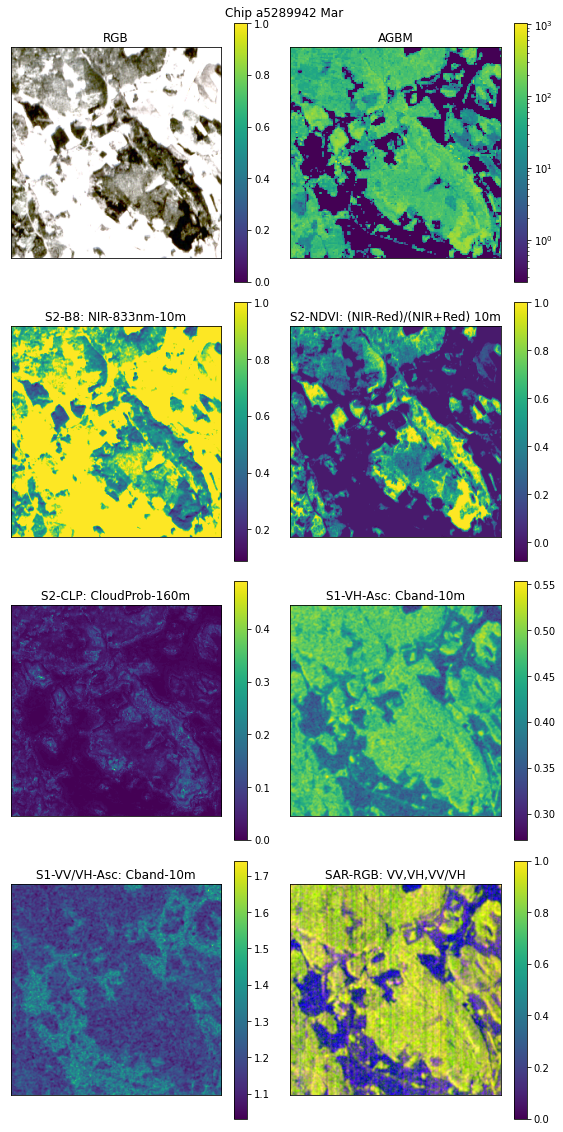

In [9]:
tile_idx = 104267 
plot_by_tile_index(dataset, tile_idx, plot_channels, CFG.CHANNEL_MAP)

In [24]:
def diff_ndvi_sar_vh(tile, ndvi_idx, vh_idx):
    ndvi = minmax_scale(tile[ndvi_idx].clamp(0))
    vh = minmax_scale(tile[vh_idx])
    return ndvi - vh

def calc_frac_over_thresh(img, thresh=0.5):
    total_vals = 256*256.
    count_bad = img[np.abs(img)>thresh].shape[0]
    count_bad += np.isnan(img).sum()
    return round((count_bad)/total_vals, 3)

def calc_quality_scores(dataset):
    scores = []
    for ix, sample in tqdm(enumerate(dataset), total=len(dataset)):
        chipid, month_idx = dataset[ix]
        tile = sample['image'].detach().clone().cpu()
        diff_img = diff_ndvi_sar_vh(tile, ndvi_idx=15, vh_idx=12)
        score = 1 - calc_frac_over_thresh(diff_img, thresh=0.5)
        scores.append((chipid, month_idx, score))
        gc.collect()
    return pd.DataFrame(scores, columns=['chipid', 'month', 'score'])

def find_best_month_score(scores: np.ndarray, high_thresh: float = 0.95, min_thresh: float = 0.9) -> int:
    '''Calculate and return the best band score per heuristics
    
    Inputs:
    scores -- quality metric for each of 12 months from Sep = 0 to Aug = 11 
    high_thresh -- high quality score threshold 
    min_thresh -- lower quality score threshold 
    '''
    
    ranked_indexes = [8, 9, 7, 10, 11, 0] # best months for vegetation data 
    
    for idx in ranked_indexes: # first see if any favored months meet high threshold
        if scores[idx] > high_thresh:
            return idx, scores[idx]

    for idx in ranked_indexes: # then try lower threshold 
        if scores[idx] > min_thresh:
            return idx, scores[idx]
    
    idx = np.argmax(scores)
    return idx, scores[idx] # otherwise return month with highest score 

def find_best_months(df_scores):
    best_months = []
    for chipid in tqdm(df_scores['chipid'].unique()):
        idx, score = find_best_month_score(df_scores[df_scores['chipid']==chipid]['score'].values)
        best_months.append((chipid, idx, score))
    return pd.DataFrame(best_months, columns=['chipid', 'month', 'score'])

In [25]:
from concurrent.futures import ProcessPoolExecutor
with ProcessPoolExecutor() as exe:
    result = exe.map(calc_quality_scores, dataset.df_tile_list)

In [ ]:
df_best = find_best_months(df_scores)
df_best.to_csv('./TILE_LIST_BEST_MONTHS.csv')

In [ ]:
dir_test = '~/DATA/biomassters/tiles/test_features/'
dataset_test = dl.SentinelDataset(tile_file=None,
                             dir_tiles=dir_test,  # change to dir_test
                             dir_target=None,     # no target tiles for test data 
                             max_chips=max_chips,
                             transform=transforms,
                             device=device
                             )

In [ ]:
df_scores_test = calc_quality_scores(dataset_test)

In [ ]:
df_best_test = find_best_months(df_scores_test)

In [18]:
import gc
gc.collect()

26

In [23]:
scores[0].result()

AttributeError: ignored